In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
train_dir = 'C:/Users/fdoktorm/OneDrive - Intel Corporation/Documents/Private/Data Science/Naya College/Final Project Brain Tumor Classification/Brain-Tumor-Classification-DataSet-master/Training/'
test_dir = 'C:/Users/fdoktorm/OneDrive - Intel Corporation/Documents/Private/Data Science/Naya College/Final Project Brain Tumor Classification/Brain-Tumor-Classification-DataSet-master/Testing/'

In [3]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):   
    print (label)
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

glioma
meningioma
notumor
pituitary


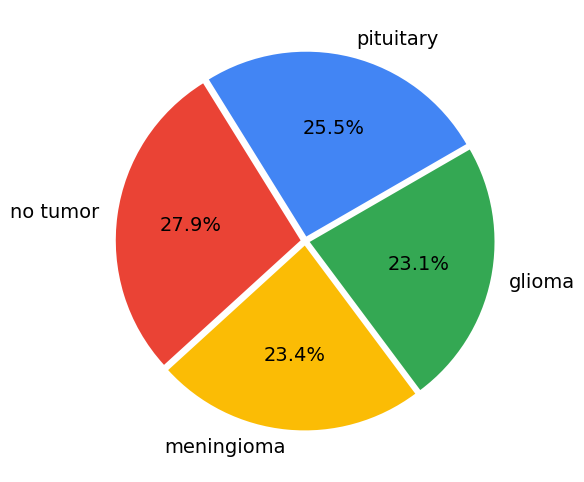

In [4]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if 'pituitary' in x]),
         len([x for x in train_labels if 'notumor' in x]),
         len([x for x in train_labels if 'meningioma' in x]),
         len([x for x in train_labels if 'glioma' in x])],
        labels=['pituitary','no tumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

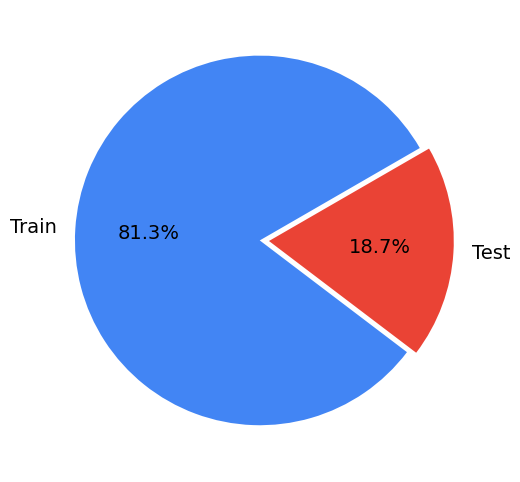

In [6]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [7]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

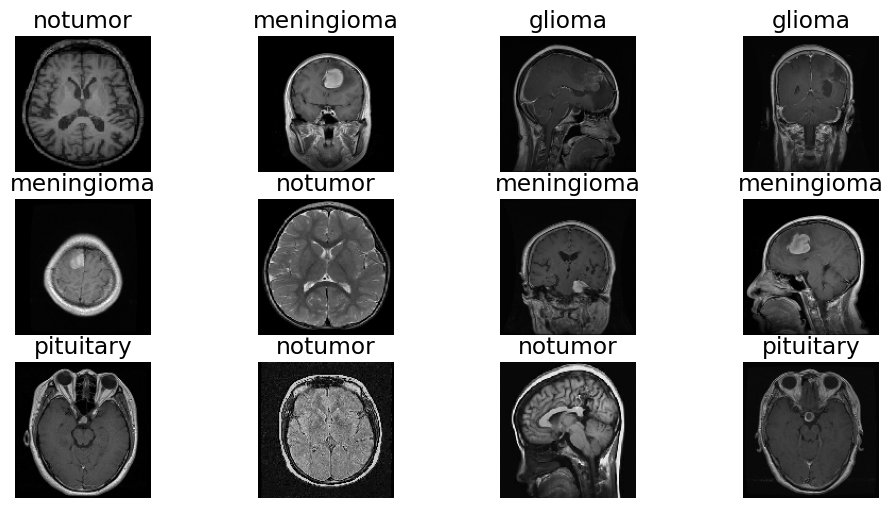

In [8]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:65])
labels = train_labels[50:65]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 13):
    fig.add_subplot(3, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [9]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [10]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(unique_labels), activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

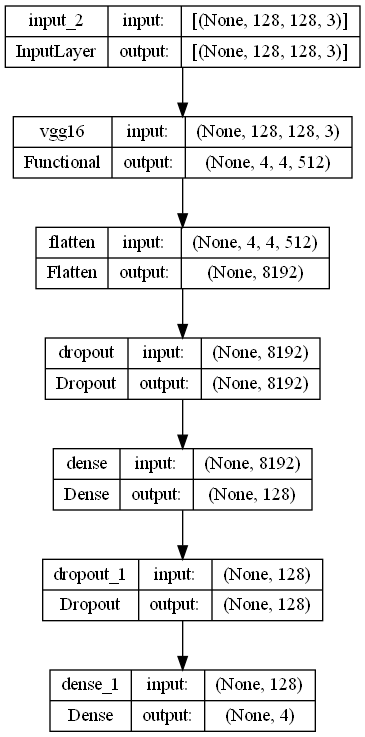

In [12]:
keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [14]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 [==============================] - 271s 947ms/step - loss: 0.4956 - sparse_categorical_accuracy: 0.8144
Epoch 2/10
285/285 [==============================] - 249s 873ms/step - loss: 0.2513 - sparse_categorical_accuracy: 0.9090
Epoch 3/10
285/285 [==============================] - 234s 821ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9353
Epoch 4/10
285/285 [==============================] - 230s 807ms/step - loss: 0.1150 - sparse_categorical_accuracy: 0.9596
Epoch 5/10
285/285 [==============================] - 228s 799ms/step - loss: 0.0974 - sparse_categorical_accuracy: 0.9668
Epoch 6/10
285/285 [==============================] - 218s 764ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9786
Epoch 7/10
285/285 [==============================] - 211s 738ms/step - loss: 0.0481 - sparse_categorical_accuracy: 0.9807
Epoch 8/10
285/285 [==============================] - 218s 764ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9809
Epoch 9/10
285/2

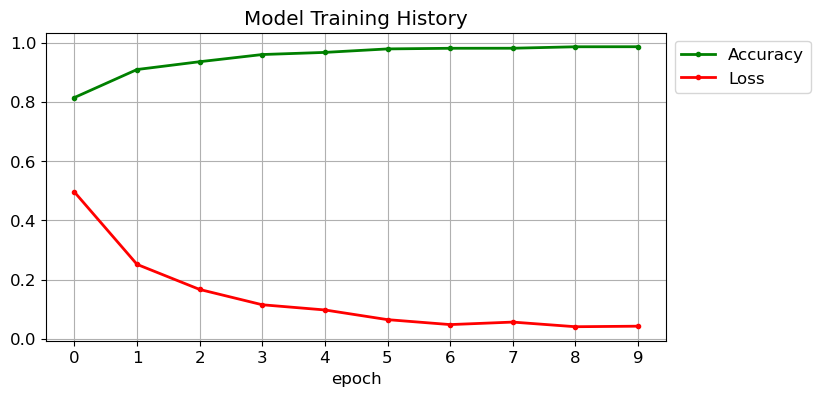

In [15]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [16]:
batch_size = 8
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                          | 0/163 [00:00<?, ?it/s]

1/1 [==============================] - 0s 435ms/step


  1%|▌                                                                                 | 1/163 [00:00<01:20,  2.01it/s]

1/1 [==============================] - 0s 283ms/step


  1%|█                                                                                 | 2/163 [00:00<01:09,  2.33it/s]

1/1 [==============================] - 0s 315ms/step


  2%|█▌                                                                                | 3/163 [00:01<01:07,  2.36it/s]

1/1 [==============================] - 0s 385ms/step


  2%|██                                                                                | 4/163 [00:01<01:10,  2.25it/s]

1/1 [==============================] - 0s 355ms/step


  3%|██▌                                                                               | 5/163 [00:02<01:10,  2.25it/s]

1/1 [==============================] - 0s 374ms/step


  4%|███                                                                               | 6/163 [00:02<01:11,  2.20it/s]

1/1 [==============================] - 0s 344ms/step


  4%|███▌                                                                              | 7/163 [00:03<01:10,  2.21it/s]

1/1 [==============================] - 0s 313ms/step


  5%|████                                                                              | 8/163 [00:03<01:07,  2.29it/s]

1/1 [==============================] - 0s 336ms/step


  6%|████▌                                                                             | 9/163 [00:03<01:06,  2.30it/s]

1/1 [==============================] - 0s 344ms/step


  6%|████▉                                                                            | 10/163 [00:04<01:07,  2.28it/s]

1/1 [==============================] - 0s 335ms/step


  7%|█████▍                                                                           | 11/163 [00:04<01:05,  2.30it/s]

1/1 [==============================] - 0s 303ms/step


  7%|█████▉                                                                           | 12/163 [00:05<01:04,  2.35it/s]

1/1 [==============================] - 0s 325ms/step


  8%|██████▍                                                                          | 13/163 [00:05<01:03,  2.35it/s]

1/1 [==============================] - 0s 316ms/step


  9%|██████▉                                                                          | 14/163 [00:06<01:02,  2.37it/s]

1/1 [==============================] - 0s 323ms/step


  9%|███████▍                                                                         | 15/163 [00:06<01:01,  2.40it/s]

1/1 [==============================] - 0s 324ms/step


 10%|███████▉                                                                         | 16/163 [00:06<01:01,  2.39it/s]

1/1 [==============================] - 0s 326ms/step


 10%|████████▍                                                                        | 17/163 [00:07<01:01,  2.37it/s]

1/1 [==============================] - 0s 333ms/step


 11%|████████▉                                                                        | 18/163 [00:07<01:01,  2.35it/s]

1/1 [==============================] - 0s 323ms/step


 12%|█████████▍                                                                       | 19/163 [00:08<01:01,  2.35it/s]

1/1 [==============================] - 0s 334ms/step


 12%|█████████▉                                                                       | 20/163 [00:08<01:00,  2.36it/s]

1/1 [==============================] - 0s 334ms/step


 13%|██████████▍                                                                      | 21/163 [00:09<01:00,  2.35it/s]

1/1 [==============================] - 0s 303ms/step


 13%|██████████▉                                                                      | 22/163 [00:09<00:59,  2.39it/s]

1/1 [==============================] - 0s 327ms/step


 14%|███████████▍                                                                     | 23/163 [00:09<00:58,  2.38it/s]

1/1 [==============================] - 0s 310ms/step


 15%|███████████▉                                                                     | 24/163 [00:10<00:57,  2.41it/s]

1/1 [==============================] - 0s 345ms/step


 15%|████████████▍                                                                    | 25/163 [00:10<00:57,  2.39it/s]

1/1 [==============================] - 0s 285ms/step


 16%|████████████▉                                                                    | 26/163 [00:11<00:56,  2.43it/s]

1/1 [==============================] - 0s 307ms/step


 17%|█████████████▍                                                                   | 27/163 [00:11<00:55,  2.44it/s]

1/1 [==============================] - 0s 324ms/step


 17%|█████████████▉                                                                   | 28/163 [00:11<00:55,  2.43it/s]

1/1 [==============================] - 0s 324ms/step


 18%|██████████████▍                                                                  | 29/163 [00:12<00:56,  2.39it/s]

1/1 [==============================] - 0s 323ms/step


 18%|██████████████▉                                                                  | 30/163 [00:12<00:55,  2.40it/s]

1/1 [==============================] - 0s 334ms/step


 19%|███████████████▍                                                                 | 31/163 [00:13<00:55,  2.39it/s]

1/1 [==============================] - 0s 331ms/step


 20%|███████████████▉                                                                 | 32/163 [00:13<00:54,  2.39it/s]

1/1 [==============================] - 0s 334ms/step


 20%|████████████████▍                                                                | 33/163 [00:14<00:54,  2.37it/s]

1/1 [==============================] - 0s 342ms/step


 21%|████████████████▉                                                                | 34/163 [00:14<00:55,  2.34it/s]

1/1 [==============================] - 0s 333ms/step


 21%|█████████████████▍                                                               | 35/163 [00:14<00:54,  2.35it/s]

1/1 [==============================] - 0s 323ms/step


 22%|█████████████████▉                                                               | 36/163 [00:15<00:53,  2.37it/s]

1/1 [==============================] - 0s 303ms/step


 23%|██████████████████▍                                                              | 37/163 [00:15<00:52,  2.42it/s]

1/1 [==============================] - 0s 313ms/step


 23%|██████████████████▉                                                              | 38/163 [00:16<00:51,  2.42it/s]

1/1 [==============================] - 0s 321ms/step


 24%|███████████████████▍                                                             | 39/163 [00:16<00:51,  2.42it/s]

1/1 [==============================] - 0s 323ms/step


 25%|███████████████████▉                                                             | 40/163 [00:16<00:50,  2.42it/s]

1/1 [==============================] - 0s 314ms/step


 25%|████████████████████▎                                                            | 41/163 [00:17<00:50,  2.43it/s]

1/1 [==============================] - 0s 315ms/step


 26%|████████████████████▊                                                            | 42/163 [00:17<00:49,  2.43it/s]

1/1 [==============================] - 0s 303ms/step


 26%|█████████████████████▎                                                           | 43/163 [00:18<00:49,  2.44it/s]

1/1 [==============================] - 0s 326ms/step


 27%|█████████████████████▊                                                           | 44/163 [00:18<00:49,  2.41it/s]

1/1 [==============================] - 0s 324ms/step


 28%|██████████████████████▎                                                          | 45/163 [00:19<00:48,  2.41it/s]

1/1 [==============================] - 0s 320ms/step


 28%|██████████████████████▊                                                          | 46/163 [00:19<00:48,  2.41it/s]

1/1 [==============================] - 0s 307ms/step


 29%|███████████████████████▎                                                         | 47/163 [00:19<00:47,  2.45it/s]

1/1 [==============================] - 0s 305ms/step


 29%|███████████████████████▊                                                         | 48/163 [00:20<00:46,  2.46it/s]

1/1 [==============================] - 0s 313ms/step


 30%|████████████████████████▎                                                        | 49/163 [00:20<00:46,  2.44it/s]

1/1 [==============================] - 0s 323ms/step


 31%|████████████████████████▊                                                        | 50/163 [00:21<00:46,  2.42it/s]

1/1 [==============================] - 0s 293ms/step


 31%|█████████████████████████▎                                                       | 51/163 [00:21<00:45,  2.47it/s]

1/1 [==============================] - 0s 312ms/step


 32%|█████████████████████████▊                                                       | 52/163 [00:21<00:44,  2.47it/s]

1/1 [==============================] - 0s 303ms/step


 33%|██████████████████████████▎                                                      | 53/163 [00:22<00:44,  2.47it/s]

1/1 [==============================] - 0s 324ms/step


 33%|██████████████████████████▊                                                      | 54/163 [00:22<00:44,  2.45it/s]

1/1 [==============================] - 0s 314ms/step


 34%|███████████████████████████▎                                                     | 55/163 [00:23<00:44,  2.42it/s]

1/1 [==============================] - 0s 313ms/step


 34%|███████████████████████████▊                                                     | 56/163 [00:23<00:43,  2.44it/s]

1/1 [==============================] - 0s 323ms/step


 35%|████████████████████████████▎                                                    | 57/163 [00:23<00:43,  2.43it/s]

1/1 [==============================] - 0s 323ms/step


 36%|████████████████████████████▊                                                    | 58/163 [00:24<00:43,  2.39it/s]

1/1 [==============================] - 0s 323ms/step


 36%|█████████████████████████████▎                                                   | 59/163 [00:24<00:43,  2.38it/s]

1/1 [==============================] - 0s 323ms/step


 37%|█████████████████████████████▊                                                   | 60/163 [00:25<00:43,  2.37it/s]

1/1 [==============================] - 0s 305ms/step


 37%|██████████████████████████████▎                                                  | 61/163 [00:25<00:42,  2.42it/s]

1/1 [==============================] - 0s 293ms/step


 38%|██████████████████████████████▊                                                  | 62/163 [00:25<00:41,  2.45it/s]

1/1 [==============================] - 0s 303ms/step


 39%|███████████████████████████████▎                                                 | 63/163 [00:26<00:40,  2.48it/s]

1/1 [==============================] - 0s 323ms/step


 39%|███████████████████████████████▊                                                 | 64/163 [00:26<00:40,  2.46it/s]

1/1 [==============================] - 0s 306ms/step


 40%|████████████████████████████████▎                                                | 65/163 [00:27<00:39,  2.46it/s]

1/1 [==============================] - 0s 301ms/step


 40%|████████████████████████████████▊                                                | 66/163 [00:27<00:38,  2.50it/s]

1/1 [==============================] - 0s 306ms/step


 41%|█████████████████████████████████▎                                               | 67/163 [00:27<00:38,  2.49it/s]

1/1 [==============================] - 0s 323ms/step


 42%|█████████████████████████████████▊                                               | 68/163 [00:28<00:38,  2.45it/s]

1/1 [==============================] - 0s 313ms/step


 42%|██████████████████████████████████▎                                              | 69/163 [00:28<00:38,  2.44it/s]

1/1 [==============================] - 0s 313ms/step


 43%|██████████████████████████████████▊                                              | 70/163 [00:29<00:38,  2.43it/s]

1/1 [==============================] - 0s 313ms/step


 44%|███████████████████████████████████▎                                             | 71/163 [00:29<00:37,  2.43it/s]

1/1 [==============================] - 0s 323ms/step


 44%|███████████████████████████████████▊                                             | 72/163 [00:30<00:37,  2.43it/s]

1/1 [==============================] - 0s 321ms/step


 45%|████████████████████████████████████▎                                            | 73/163 [00:30<00:37,  2.42it/s]

1/1 [==============================] - 0s 311ms/step


 45%|████████████████████████████████████▊                                            | 74/163 [00:30<00:36,  2.44it/s]

1/1 [==============================] - 0s 323ms/step


 46%|█████████████████████████████████████▎                                           | 75/163 [00:31<00:36,  2.41it/s]

1/1 [==============================] - 0s 333ms/step


 47%|█████████████████████████████████████▊                                           | 76/163 [00:31<00:36,  2.38it/s]

1/1 [==============================] - 0s 348ms/step


 47%|██████████████████████████████████████▎                                          | 77/163 [00:32<00:36,  2.35it/s]

1/1 [==============================] - 0s 313ms/step


 48%|██████████████████████████████████████▊                                          | 78/163 [00:32<00:35,  2.40it/s]

1/1 [==============================] - 0s 323ms/step


 48%|███████████████████████████████████████▎                                         | 79/163 [00:33<00:35,  2.39it/s]

1/1 [==============================] - 0s 334ms/step


 49%|███████████████████████████████████████▊                                         | 80/163 [00:33<00:35,  2.36it/s]

1/1 [==============================] - 0s 376ms/step


 50%|████████████████████████████████████████▎                                        | 81/163 [00:33<00:36,  2.27it/s]

1/1 [==============================] - 0s 334ms/step


 50%|████████████████████████████████████████▋                                        | 82/163 [00:34<00:35,  2.29it/s]

1/1 [==============================] - 0s 324ms/step


 51%|█████████████████████████████████████████▏                                       | 83/163 [00:34<00:34,  2.31it/s]

1/1 [==============================] - 0s 444ms/step


 52%|█████████████████████████████████████████▋                                       | 84/163 [00:35<00:36,  2.14it/s]

1/1 [==============================] - 0s 354ms/step


 52%|██████████████████████████████████████████▏                                      | 85/163 [00:35<00:35,  2.17it/s]

1/1 [==============================] - 0s 364ms/step


 53%|██████████████████████████████████████████▋                                      | 86/163 [00:36<00:35,  2.15it/s]

1/1 [==============================] - 0s 343ms/step


 53%|███████████████████████████████████████████▏                                     | 87/163 [00:36<00:34,  2.19it/s]

1/1 [==============================] - 0s 271ms/step


 54%|███████████████████████████████████████████▋                                     | 88/163 [00:37<00:32,  2.32it/s]

1/1 [==============================] - 0s 303ms/step


 55%|████████████████████████████████████████████▏                                    | 89/163 [00:37<00:30,  2.39it/s]

1/1 [==============================] - 0s 332ms/step


 55%|████████████████████████████████████████████▋                                    | 90/163 [00:37<00:30,  2.36it/s]

1/1 [==============================] - 0s 266ms/step


 56%|█████████████████████████████████████████████▏                                   | 91/163 [00:38<00:29,  2.46it/s]

1/1 [==============================] - 0s 309ms/step


 56%|█████████████████████████████████████████████▋                                   | 92/163 [00:38<00:28,  2.47it/s]

1/1 [==============================] - 0s 334ms/step


 57%|██████████████████████████████████████████████▏                                  | 93/163 [00:39<00:28,  2.42it/s]

1/1 [==============================] - 0s 245ms/step


 58%|██████████████████████████████████████████████▋                                  | 94/163 [00:39<00:27,  2.54it/s]

1/1 [==============================] - 0s 222ms/step


 58%|███████████████████████████████████████████████▏                                 | 95/163 [00:39<00:25,  2.69it/s]

1/1 [==============================] - 0s 233ms/step


 59%|███████████████████████████████████████████████▋                                 | 96/163 [00:40<00:23,  2.79it/s]

1/1 [==============================] - 0s 213ms/step


 60%|████████████████████████████████████████████████▏                                | 97/163 [00:40<00:22,  2.90it/s]

1/1 [==============================] - 0s 253ms/step


 60%|████████████████████████████████████████████████▋                                | 98/163 [00:40<00:22,  2.88it/s]

1/1 [==============================] - 0s 233ms/step


 61%|█████████████████████████████████████████████████▏                               | 99/163 [00:41<00:21,  2.92it/s]

1/1 [==============================] - 0s 202ms/step


 61%|█████████████████████████████████████████████████                               | 100/163 [00:41<00:21,  2.99it/s]

1/1 [==============================] - 0s 231ms/step


 62%|█████████████████████████████████████████████████▌                              | 101/163 [00:41<00:20,  3.02it/s]

1/1 [==============================] - 0s 223ms/step


 63%|██████████████████████████████████████████████████                              | 102/163 [00:42<00:20,  3.02it/s]

1/1 [==============================] - 0s 223ms/step


 63%|██████████████████████████████████████████████████▌                             | 103/163 [00:42<00:19,  3.07it/s]

1/1 [==============================] - 0s 319ms/step


 64%|███████████████████████████████████████████████████                             | 104/163 [00:42<00:20,  2.86it/s]

1/1 [==============================] - 0s 243ms/step


 64%|███████████████████████████████████████████████████▌                            | 105/163 [00:43<00:20,  2.87it/s]

1/1 [==============================] - 0s 268ms/step


 65%|████████████████████████████████████████████████████                            | 106/163 [00:43<00:20,  2.83it/s]

1/1 [==============================] - 0s 222ms/step


 66%|████████████████████████████████████████████████████▌                           | 107/163 [00:43<00:19,  2.93it/s]

1/1 [==============================] - 0s 214ms/step


 66%|█████████████████████████████████████████████████████                           | 108/163 [00:44<00:18,  3.01it/s]

1/1 [==============================] - 0s 202ms/step


 67%|█████████████████████████████████████████████████████▍                          | 109/163 [00:44<00:17,  3.06it/s]

1/1 [==============================] - 0s 221ms/step


 67%|█████████████████████████████████████████████████████▉                          | 110/163 [00:44<00:17,  3.10it/s]

1/1 [==============================] - 0s 233ms/step


 68%|██████████████████████████████████████████████████████▍                         | 111/163 [00:45<00:16,  3.07it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████████████████████████████████████████████████████▉                         | 112/163 [00:45<00:16,  3.05it/s]

1/1 [==============================] - 0s 303ms/step


 69%|███████████████████████████████████████████████████████▍                        | 113/163 [00:45<00:17,  2.85it/s]

1/1 [==============================] - 0s 212ms/step


 70%|███████████████████████████████████████████████████████▉                        | 114/163 [00:46<00:16,  2.95it/s]

1/1 [==============================] - 0s 215ms/step


 71%|████████████████████████████████████████████████████████▍                       | 115/163 [00:46<00:16,  2.98it/s]

1/1 [==============================] - 0s 223ms/step


 71%|████████████████████████████████████████████████████████▉                       | 116/163 [00:46<00:15,  3.01it/s]

1/1 [==============================] - 0s 224ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 117/163 [00:47<00:15,  3.03it/s]

1/1 [==============================] - 0s 204ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 118/163 [00:47<00:14,  3.10it/s]

1/1 [==============================] - 0s 222ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 119/163 [00:47<00:14,  3.12it/s]

1/1 [==============================] - 0s 255ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 120/163 [00:48<00:14,  3.03it/s]

1/1 [==============================] - 0s 273ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 121/163 [00:48<00:14,  2.92it/s]

1/1 [==============================] - 0s 212ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 122/163 [00:48<00:13,  3.02it/s]

1/1 [==============================] - 0s 212ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 123/163 [00:49<00:13,  3.05it/s]

1/1 [==============================] - 0s 233ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 124/163 [00:49<00:12,  3.06it/s]

1/1 [==============================] - 0s 212ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 125/163 [00:49<00:12,  3.10it/s]

1/1 [==============================] - 0s 222ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 126/163 [00:50<00:12,  3.07it/s]

1/1 [==============================] - 0s 222ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 127/163 [00:50<00:11,  3.06it/s]

1/1 [==============================] - 0s 212ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 128/163 [00:50<00:11,  3.13it/s]

1/1 [==============================] - 0s 222ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 129/163 [00:50<00:10,  3.09it/s]

1/1 [==============================] - 0s 212ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 130/163 [00:51<00:10,  3.15it/s]

1/1 [==============================] - 0s 232ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 131/163 [00:51<00:10,  3.10it/s]

1/1 [==============================] - 0s 223ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 132/163 [00:51<00:10,  3.08it/s]

1/1 [==============================] - 0s 215ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 133/163 [00:52<00:09,  3.12it/s]

1/1 [==============================] - 0s 253ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 134/163 [00:52<00:09,  3.05it/s]

1/1 [==============================] - 0s 222ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 135/163 [00:52<00:09,  3.04it/s]

1/1 [==============================] - 0s 251ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 136/163 [00:53<00:09,  3.00it/s]

1/1 [==============================] - 0s 220ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 137/163 [00:53<00:08,  3.05it/s]

1/1 [==============================] - 0s 214ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 138/163 [00:53<00:08,  3.09it/s]

1/1 [==============================] - 0s 222ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 139/163 [00:54<00:07,  3.09it/s]

1/1 [==============================] - 0s 213ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 140/163 [00:54<00:07,  3.12it/s]

1/1 [==============================] - 0s 214ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 141/163 [00:54<00:07,  3.11it/s]

1/1 [==============================] - 0s 212ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 142/163 [00:55<00:06,  3.11it/s]

1/1 [==============================] - 0s 233ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 143/163 [00:55<00:06,  3.08it/s]

1/1 [==============================] - 0s 243ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 144/163 [00:55<00:06,  3.05it/s]

1/1 [==============================] - 0s 273ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 145/163 [00:56<00:06,  2.93it/s]

1/1 [==============================] - 0s 212ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 146/163 [00:56<00:05,  3.00it/s]

1/1 [==============================] - 0s 223ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 147/163 [00:56<00:05,  3.05it/s]

1/1 [==============================] - 0s 234ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 148/163 [00:57<00:04,  3.02it/s]

1/1 [==============================] - 0s 212ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 149/163 [00:57<00:04,  3.13it/s]

1/1 [==============================] - 0s 225ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 150/163 [00:57<00:04,  3.09it/s]

1/1 [==============================] - 0s 233ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 151/163 [00:58<00:03,  3.06it/s]

1/1 [==============================] - 0s 231ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 152/163 [00:58<00:03,  3.07it/s]

1/1 [==============================] - 0s 212ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 153/163 [00:58<00:03,  3.08it/s]

1/1 [==============================] - 0s 212ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 154/163 [00:59<00:02,  3.12it/s]

1/1 [==============================] - 0s 273ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 155/163 [00:59<00:02,  3.02it/s]

1/1 [==============================] - 0s 223ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 156/163 [00:59<00:02,  3.04it/s]

1/1 [==============================] - 0s 212ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 157/163 [01:00<00:01,  3.11it/s]

1/1 [==============================] - 0s 222ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 158/163 [01:00<00:01,  3.11it/s]

1/1 [==============================] - 0s 233ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 159/163 [01:00<00:01,  3.10it/s]

1/1 [==============================] - 0s 212ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 160/163 [01:01<00:00,  3.10it/s]

1/1 [==============================] - 0s 300ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 161/163 [01:01<00:00,  2.91it/s]

1/1 [==============================] - 0s 212ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 162/163 [01:01<00:00,  2.99it/s]

1/1 [==============================] - 0s 223ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [01:02<00:00,  3.02it/s]

1/1 [==============================] - 0s 194ms/step


164it [01:02,  2.63it/s]                                                                                               


In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.94      0.95      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311

